# 0.0 - Imports

In [1]:
import pickle
import optuna
import warnings
import itertools
import numpy                  as np
import pandas                 as pd
import seaborn                as sns
import matplotlib.pyplot      as plt
import plotly.express         as px
     
from datetime                 import datetime
from prophet                  import Prophet
from pandas.api.types         import CategoricalDtype
from IPython.display          import display, HTML
from prophet                  import Prophet
from prophet.plot             import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from sklearn.metrics          import mean_squared_error, mean_absolute_error
from sklearn.impute           import SimpleImputer
from prophet.diagnostics      import cross_validation, performance_metrics
from sklearn.preprocessing    import MinMaxScaler
from xgboost                  import XGBRegressor, plot_importance
from sklearn.metrics          import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.model_selection  import cross_validate, cross_val_score

# 0.1 - Helper Functions

In [2]:
# Set the width of the container
display(HTML("<style>.container { width:100% !important; }</style>"))

# Adjust the output area for better display without causing overlap
display(HTML("""
<style>
.output {
    display: block;
    width: 100% !important;
    max-height: 1000px !important;
    overflow-y: auto;
}
.output_area {
    width: 100% !important;
    max-height: 1000px !important;
}
</style>
"""))


warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


weekday_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

def create_features(df):
    df = df.copy()    
    df['hour'] = df['Data_Hora'].dt.hour.astype('int64')
    df['dayofweek'] = df['Data_Hora'].dt.dayofweek.astype('int64')
    df['quarter'] = df['Data_Hora'].dt.quarter.astype('int64')
    df['month'] = df['Data_Hora'].dt.month.astype('int64')
    df['year'] = df['Data_Hora'].dt.year.astype('int64')
    df['dayofyear'] = df['Data_Hora'].dt.dayofyear.astype('int64')
    df['dayofmonth'] = df['Data_Hora'].dt.day.astype('int64')
    df['weekofyear'] = df['Data_Hora'].dt.isocalendar().week.astype('int64')

    df['season'] = 'Winter'  # Default to Winter
    df.loc[(df['Data_Hora'] >= df.apply(lambda row: pd.Timestamp(year=row['year'], month=3, day=20), axis=1)) & (df['Data_Hora'] < df.apply(lambda row: pd.Timestamp(year=row['year'], month=6, day=21), axis=1)), 'season'] = 'Spring'
    df.loc[(df['Data_Hora'] >= df.apply(lambda row: pd.Timestamp(year=row['year'], month=6, day=21), axis=1)) & (df['Data_Hora'] < df.apply(lambda row: pd.Timestamp(year=row['year'], month=9, day=23), axis=1)), 'season'] = 'Summer'
    df.loc[(df['Data_Hora'] >= df.apply(lambda row: pd.Timestamp(year=row['year'], month=9, day=23), axis=1)) & (df['Data_Hora'] < df.apply(lambda row: pd.Timestamp(year=row['year'], month=12, day=22), axis=1)), 'season'] = 'Fall'
    df.loc[(df['Data_Hora'] >= df.apply(lambda row: pd.Timestamp(year=row['year'], month=12, day=22), axis=1)) | (df['Data_Hora'] < df.apply(lambda row: pd.Timestamp(year=row['year'], month=3, day=20), axis=1)), 'season'] = 'Winter'
    
    season_map = {'Winter': 4, 'Spring': 1, 'Summer': 2, 'Fall': 3}
    df['season'] = df['season'].map(season_map).astype('int64')
    
    return df

def add_lags(df):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    
    df['tem_lag_1'] = df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].shift(364)
    df['tem_lag_2'] = df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].shift(728)
    df['tem_lag_3'] = df['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'].shift(1092)

    df = df.reset_index()
    df.drop('index', axis=1, inplace=True)
    
    return df

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 0.1 - Data

In [3]:
dfs = []

for i in range(2002, 2019):
    file = rf"C:\Users\gfurt\Ciência de dados\Séries temporais\inmet_prophet\Dados\INMET_SE_RJ_A601_ECOLOGIA AGRICOLA_01-01-{i}_A_31-12-{i}.csv"
    df = pd.read_csv(file, encoding='ISO-8859-1', delimiter=';', skiprows=8)
    dfs.append(df)
    
df_raw_1 = pd.concat(dfs, ignore_index=True)

In [4]:
cols = df_raw_1.columns
dfs = []

for i in range(2019, 2024):
    file = rf"C:\Users\gfurt\Ciência de dados\Séries temporais\inmet_prophet\Dados\INMET_SE_RJ_A601_SEROPEDICA-ECOLOGIA AGRICOLA_01-01-{i}_A_31-12-{i}.csv"
    df = pd.read_csv(file, encoding='ISO-8859-1', delimiter=';', skiprows=9,
                     names=cols)
    dfs.append(df)
    
df_raw_2 = pd.concat(dfs, ignore_index=True)

In [5]:
df_raw_2['HORA (UTC)'] = df_raw_2['HORA (UTC)'].str[:4]
df_raw_2['HORA (UTC)'] = df_raw_2['HORA (UTC)'].apply(lambda x: datetime.strptime(x, '%H%M').strftime('%H:%M'))

In [6]:
df_raw_1['DATA (YYYY-MM-DD)'] = pd.to_datetime(df_raw_1['DATA (YYYY-MM-DD)'])

df_raw_2['DATA (YYYY-MM-DD)'] = pd.to_datetime(df_raw_2['DATA (YYYY-MM-DD)'])

In [7]:
df_raw = pd.concat([df_raw_1, df_raw_2], ignore_index=True)

# 1.0 - Data description

In [8]:
df1 = df_raw.copy()

## 1.1 - Data dimensions

In [9]:
df1.shape

(192840, 20)

## 1.2 - Data Type

In [10]:
df1.dtypes

DATA (YYYY-MM-DD)                                        datetime64[ns]
HORA (UTC)                                                       object
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                                 object
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)            object
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)                  object
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)                 object
RADIACAO GLOBAL (KJ/m²)                                          object
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)                     object
TEMPERATURA DO PONTO DE ORVALHO (°C)                             object
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)                       object
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)                       object
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)                 object
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)                 object
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                        

In [11]:
columns = df1.columns[2:]

for i in columns:
    df1[i] = df1[i].astype(str)
    df1[i] = df1[i].str.replace(',', '.')
    df1[i] = df1[i].astype(float)

In [12]:
df1.dtypes

DATA (YYYY-MM-DD)                                        datetime64[ns]
HORA (UTC)                                                       object
PRECIPITAÇÃO TOTAL, HORÁRIO (mm)                                float64
PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)           float64
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)                 float64
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)                float64
RADIACAO GLOBAL (KJ/m²)                                         float64
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)                    float64
TEMPERATURA DO PONTO DE ORVALHO (°C)                            float64
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)                      float64
TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)                      float64
TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)                float64
TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)                float64
UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)                        

## 1.3 - Missing Values

In [13]:
total_values = df1.shape[0]
missing_values = df1.isnull().sum()
percent_missing = (missing_values / total_values) * 100

missing_data_table = pd.DataFrame({
    'Total': total_values,
    'Missing': missing_values,
    'Percent Missing': percent_missing
})

missing_data_table['Percent Missing'] = missing_data_table['Percent Missing'].map(lambda x: f'{x:.2f}%')
missing_data_table

,Total,Missing,Percent Missing
DATA (YYYY-MM-DD),192840,0,0.00%
HORA (UTC),192840,0,0.00%
"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)",192840,2296,1.19%
"PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",192840,2196,1.14%
PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),192840,2201,1.14%
PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),192840,2201,1.14%
RADIACAO GLOBAL (KJ/m²),192840,20770,10.77%
"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",192840,962,0.50%
TEMPERATURA DO PONTO DE ORVALHO (°C),192840,962,0.50%
TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),192840,969,0.50%


## 1.4 - Descriptive statistics

In [14]:
df1.describe()

,DATA (YYYY-MM-DD),"PRECIPITAÇÃO TOTAL, HORÁRIO (mm)","PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)",PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB),PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB),RADIACAO GLOBAL (KJ/m²),"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)",TEMPERATURA DO PONTO DE ORVALHO (°C),TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C),TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C),TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C),UMIDADE REL. MAX. NA HORA ANT. (AUT) (%),UMIDADE REL. MIN. NA HORA ANT. (AUT) (%),"UMIDADE RELATIVA DO AR, HORARIA (%)","VENTO, DIREÇÃO HORARIA (gr) (° (gr))","VENTO, RAJADA MAXIMA (m/s)","VENTO, VELOCIDADE HORARIA (m/s)",Unnamed: 19
count,192840,190544.000000,190644.000000,190639.000000,190639.000000,172070.000000,191878.000000,191878.000000,191871.000000,191872.000000,191872.000000,191871.000000,191872.000000,191872.000000,191878.000000,191881.000000,191873.000000,191881.000000,0.0
mean,2012-12-31 00:00:00,-546.106078,513.676597,508.019335,507.527419,-2646.579677,-426.784848,-436.743821,-429.414992,-430.425210,-439.893117,-440.796756,-380.795619,-386.381004,-379.924608,-652.901163,-508.482934,-500.918342,NaN
min,2002-01-01 00:00:00,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,-9999.000000,NaN
25%,2007-07-02 00:00:00,0.000000,1008.200000,1008.400000,1007.900000,-9999.000000,20.200000,16.600000,20.600000,19.700000,17.100000,16.100000,66.000000,58.000000,62.000000,31.000000,2.000000,0.600000,NaN
50%,2012-12-31 00:00:00,0.000000,1011.400000,1011.700000,1011.200000,62.200000,23.100000,19.200000,23.600000,22.600000,19.600000,18.700000,84.000000,76.000000,80.000000,195.000000,3.800000,1.600000,NaN
75%,2018-07-02 00:00:00,0.000000,1015.100000,1015.400000,1014.900000,1246.800000,26.300000,21.300000,27.100000,25.600000,21.700000,20.900000,93.000000,90.000000,92.000000,299.000000,6.200000,2.800000,NaN
max,2023-12-31 00:00:00,66.200000,1029.700000,1029.700000,1029.400000,6300.200000,42.400000,27.200000,42.600000,41.500000,27.600000,26.800000,100.000000,100.000000,100.000000,360.000000,39.900000,13.700000,NaN
std,NaN,2272.330083,2288.979966,2301.906344,2301.798652,5294.042664,2076.675194,2087.574292,2083.820176,2083.342623,2095.547655,2095.355405,2105.421488,2105.094332,2097.399881,2807.378519,2206.432142,2185.457001,NaN


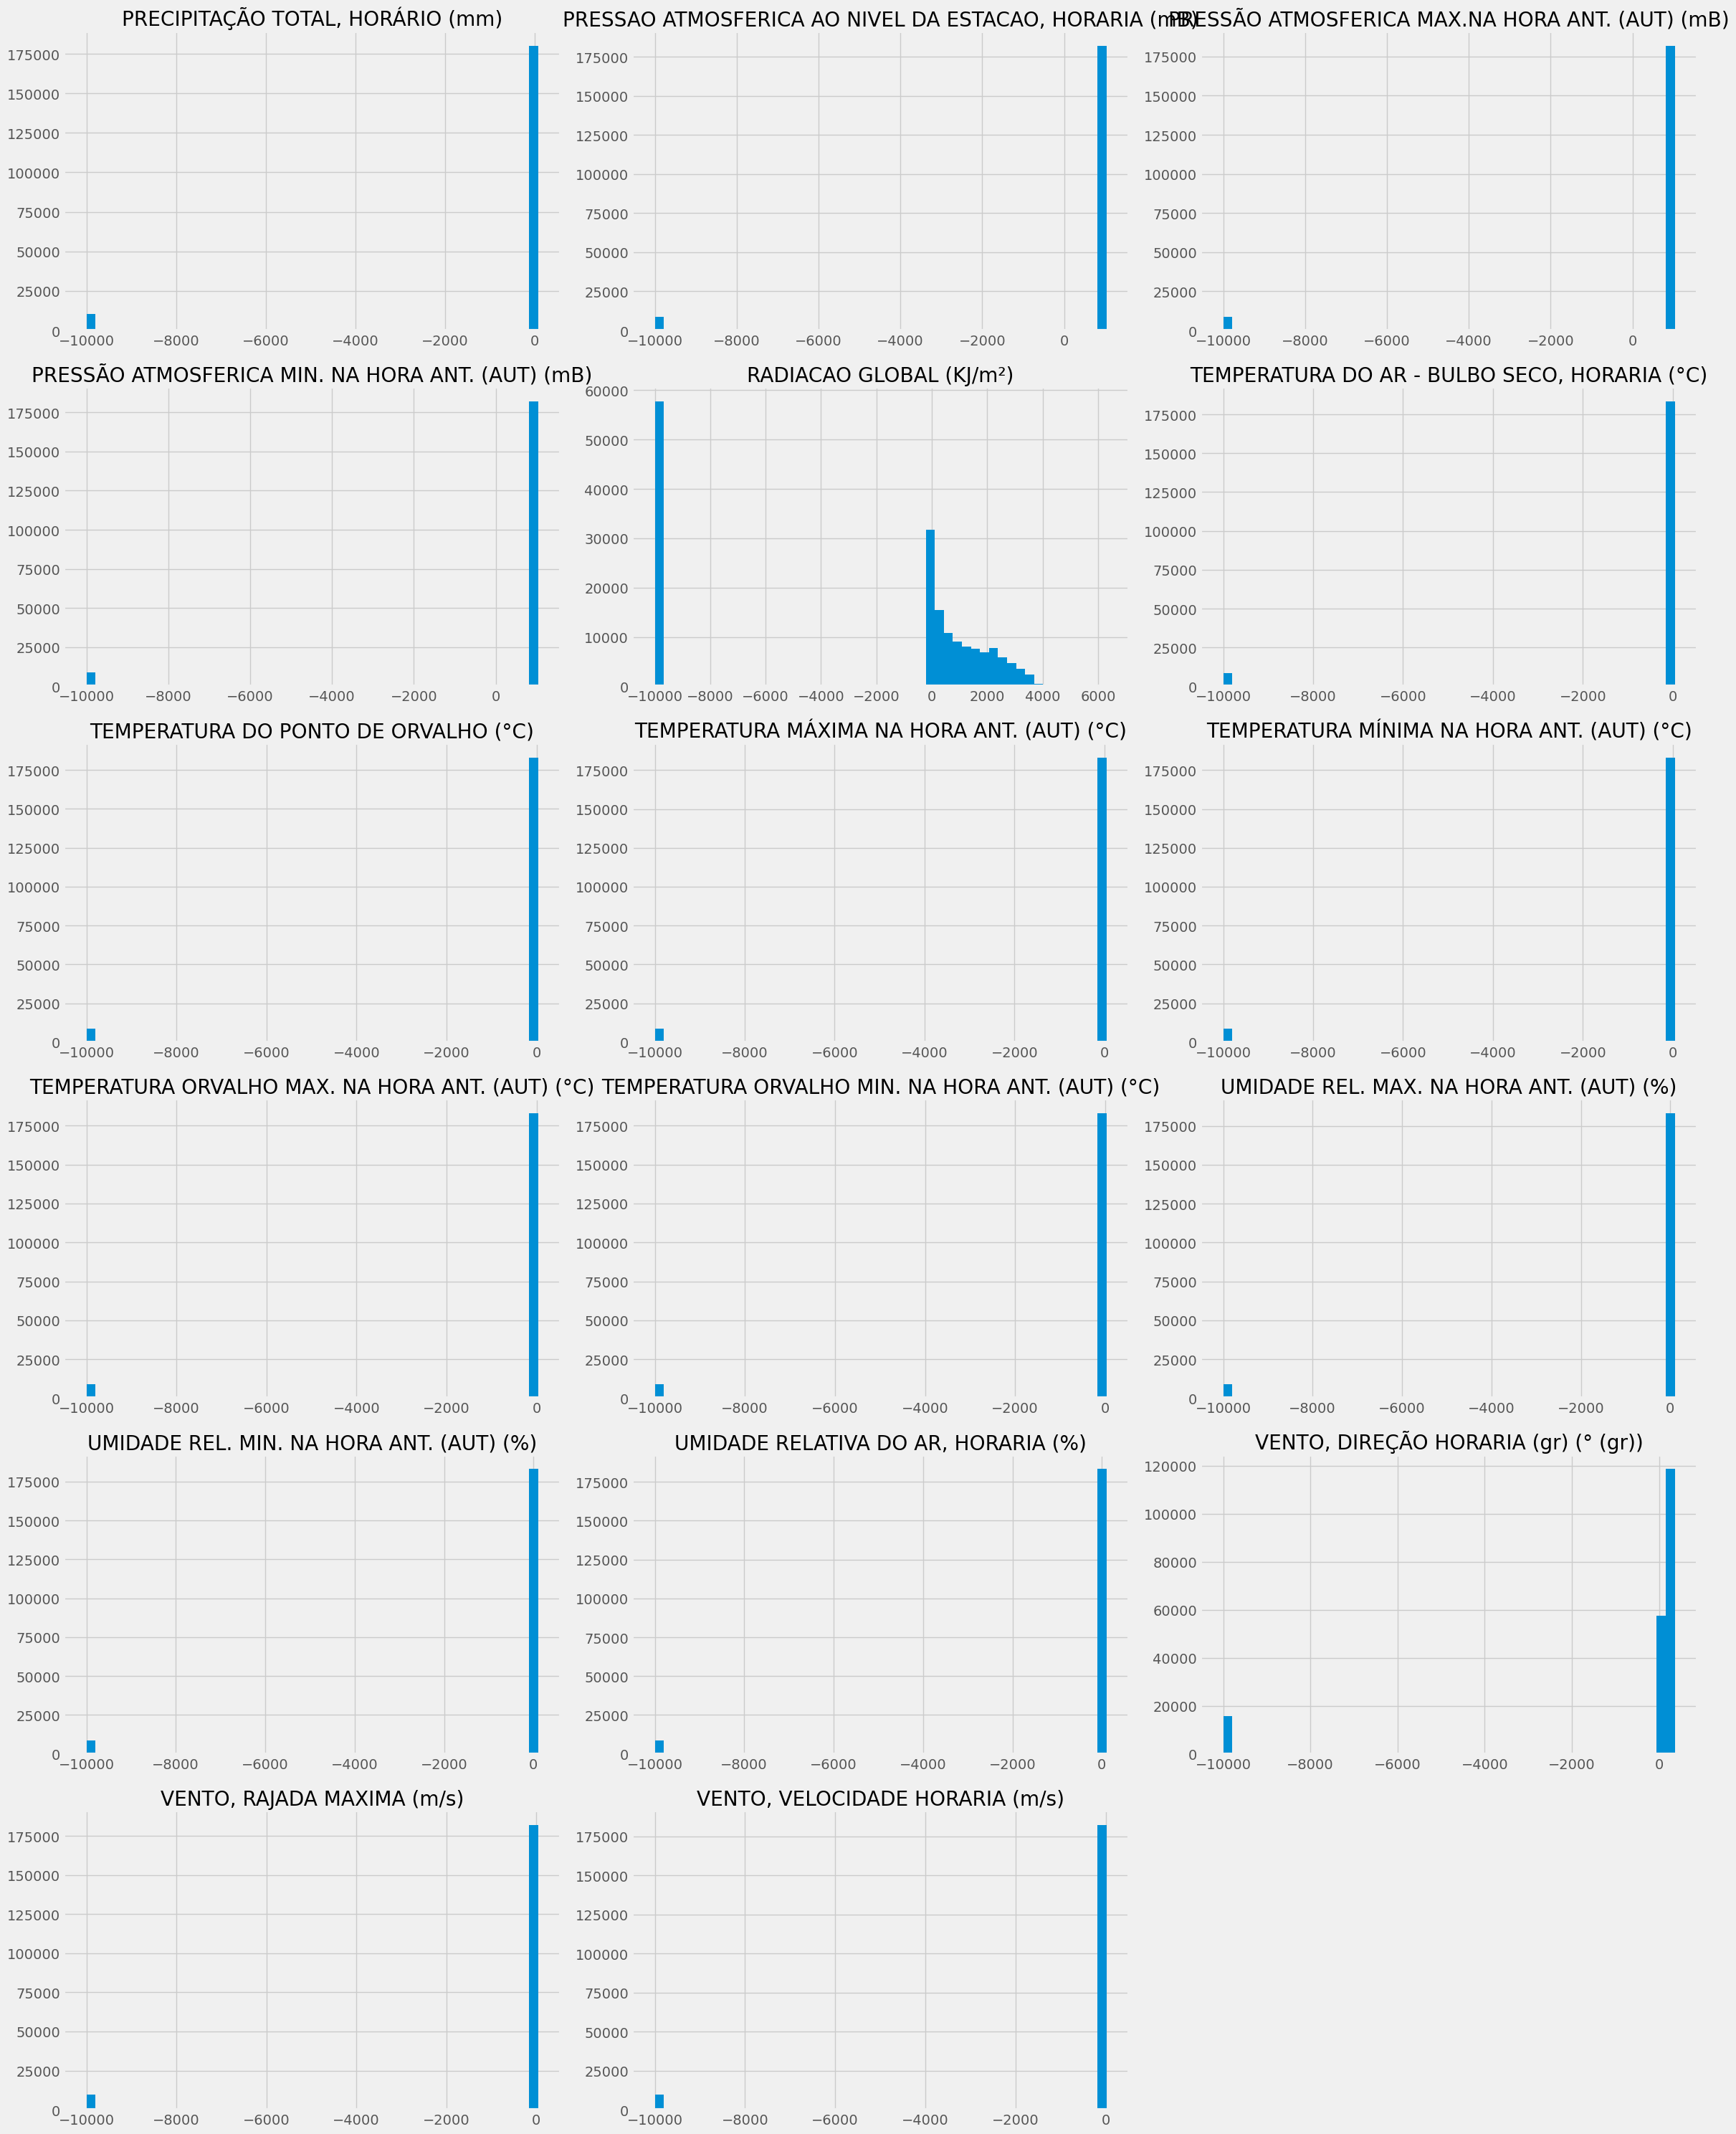

In [15]:
df_aux = df1.iloc[:,2:-1].copy()

num_columns = len(df_aux.columns)
num_rows = (num_columns + 3) // 3 

fig, axes = plt.subplots(num_rows, 3, figsize=(24, 5 * num_rows)) 
axes = axes.flatten()

for i, col in enumerate(df_aux.columns):
    df_aux[col].hist(bins=50, ax=axes[i])
    axes[i].set_title(col)

    
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


# 2.0 - Feature engineering

In [16]:
df2 = df1.copy()

## 2.1 - Timestamp

In [17]:
df2['HORA (UTC)'] = pd.to_timedelta(df2['HORA (UTC)'] + ':00')
df2['Data_Hora'] = df2['DATA (YYYY-MM-DD)'] + df2['HORA (UTC)']

df2['Data_Hora'] = pd.to_datetime(df2['Data_Hora'])

## 2.2 - Temporal Feature

In [18]:
df2 = create_features(df2)

# 3.0 - Data Cleaning

In [19]:
df3 = df2.copy()

## 3.1 - Replace -9999 values for nan

In [20]:
df3 = df3.replace(-9999, np.nan)

## 3.2 - Removing columns

In [21]:
columns_ordered = [
    'Data_Hora', 'hour', 'dayofweek', 'quarter', 'month', 'year',
    'dayofyear', 'dayofmonth', 'weekofyear', 'season',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'
]

df3 = df3.reindex(columns=columns_ordered)

## 3.4 - Missing values

In [22]:
imputer = SimpleImputer(strategy='mean')

df3['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'] = imputer.fit_transform(df3[['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']])

df3.isnull().sum()

Data_Hora                                       0
hour                                            0
dayofweek                                       0
quarter                                         0
month                                           0
year                                            0
dayofyear                                       0
dayofmonth                                      0
weekofyear                                      0
season                                          0
TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)    0
dtype: int64

# 4.0 - Exploratory Data Analysis

In [23]:
df4 = df3.copy()

In [24]:
num_attributes = df4.select_dtypes(include=['int64', 'float64'])

num_attributes.describe()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)"
count,192840.000000,192840.000000,192840.000000,192840.000000,192840.000000,192840.000000,192840.000000,192840.000000,192840.000000,192840.000000
mean,11.500000,3.000373,2.508650,6.523211,2012.499689,183.113877,15.728811,26.595520,2.474922,23.741777
std,6.922205,1.999850,1.117057,3.448635,6.343913,105.432327,8.799766,15.061586,1.114354,4.415548
min,0.000000,0.000000,1.000000,1.000000,2002.000000,1.000000,1.000000,1.000000,1.000000,8.600000
25%,5.750000,1.000000,2.000000,4.000000,2007.000000,92.000000,8.000000,14.000000,1.000000,20.800000
50%,11.500000,3.000000,3.000000,7.000000,2012.000000,183.000000,16.000000,27.000000,2.000000,23.600000
75%,17.250000,5.000000,4.000000,10.000000,2018.000000,274.000000,23.000000,40.000000,3.000000,26.300000
max,23.000000,6.000000,4.000000,12.000000,2023.000000,366.000000,31.000000,53.000000,4.000000,42.400000


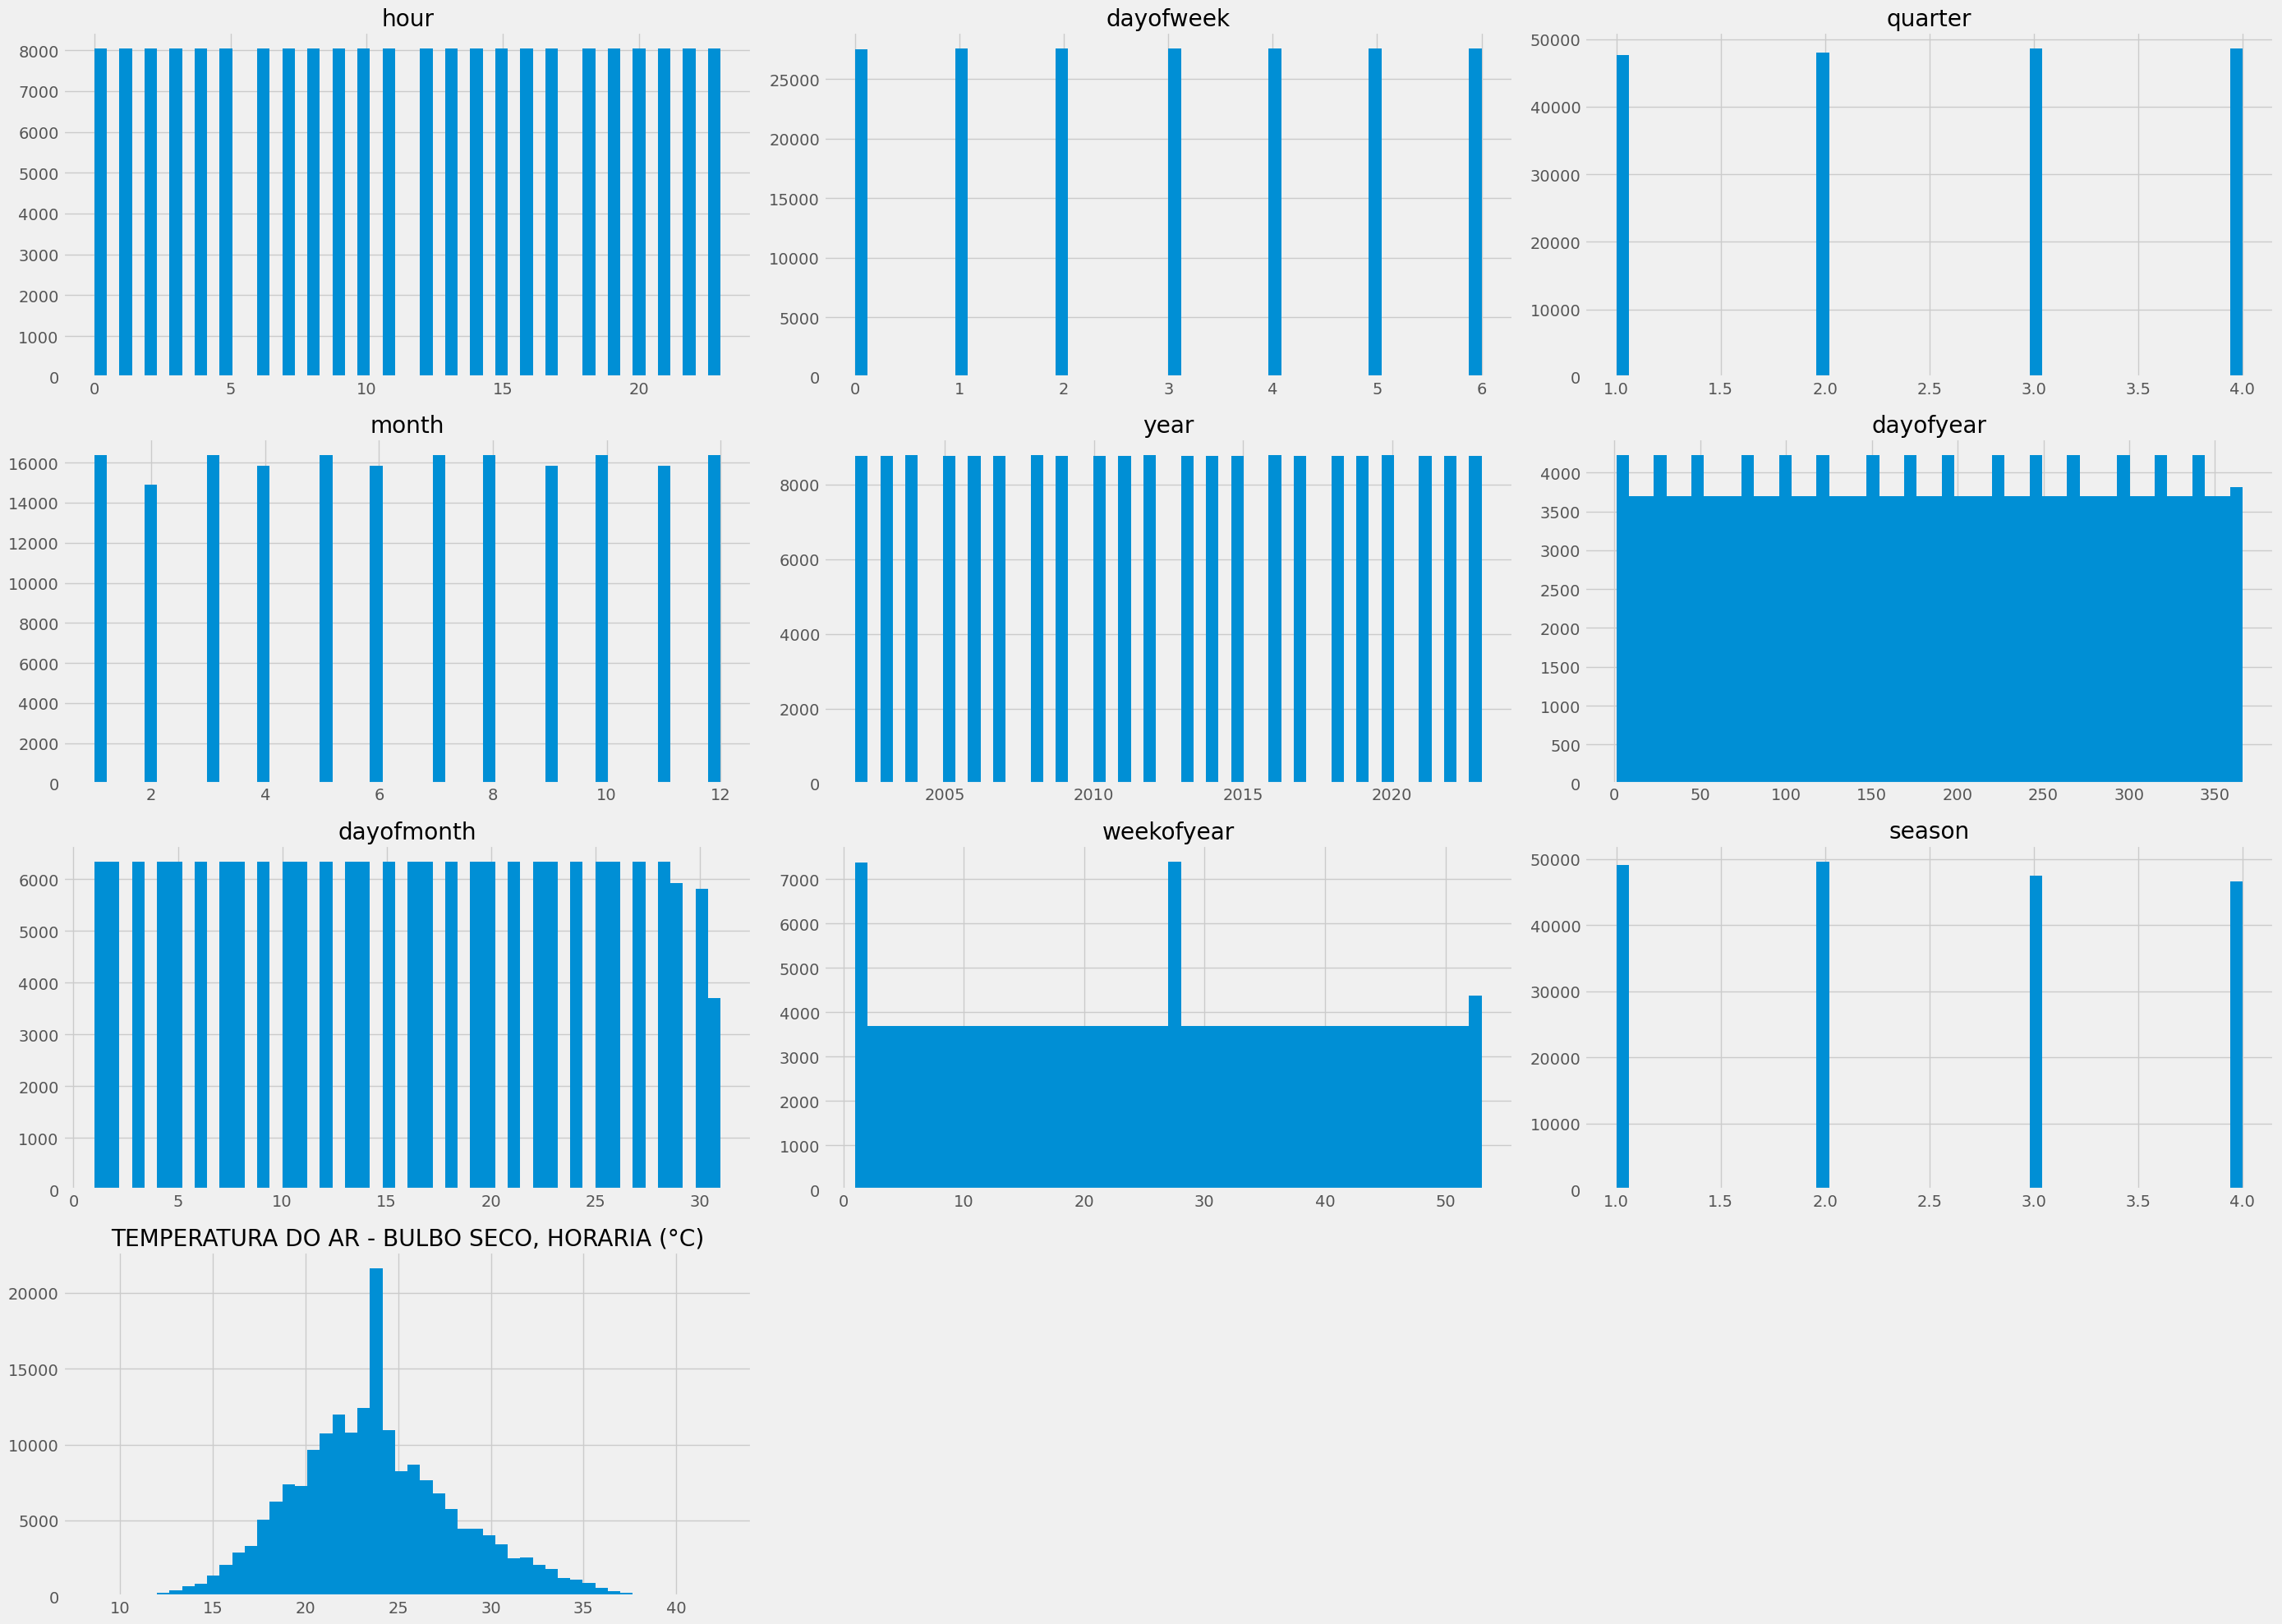

In [25]:
num_columns = len(num_attributes.columns)
num_rows = (num_columns + 3) // 3

fig, axes = plt.subplots(num_rows, 3, figsize=(28, 5 * num_rows))
axes = axes.flatten()

for i, col in enumerate(num_attributes.columns):
    num_attributes[col].hist(bins=50, ax=axes[i])
    axes[i].set_title(col)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 4.1 - Univariate Analysis

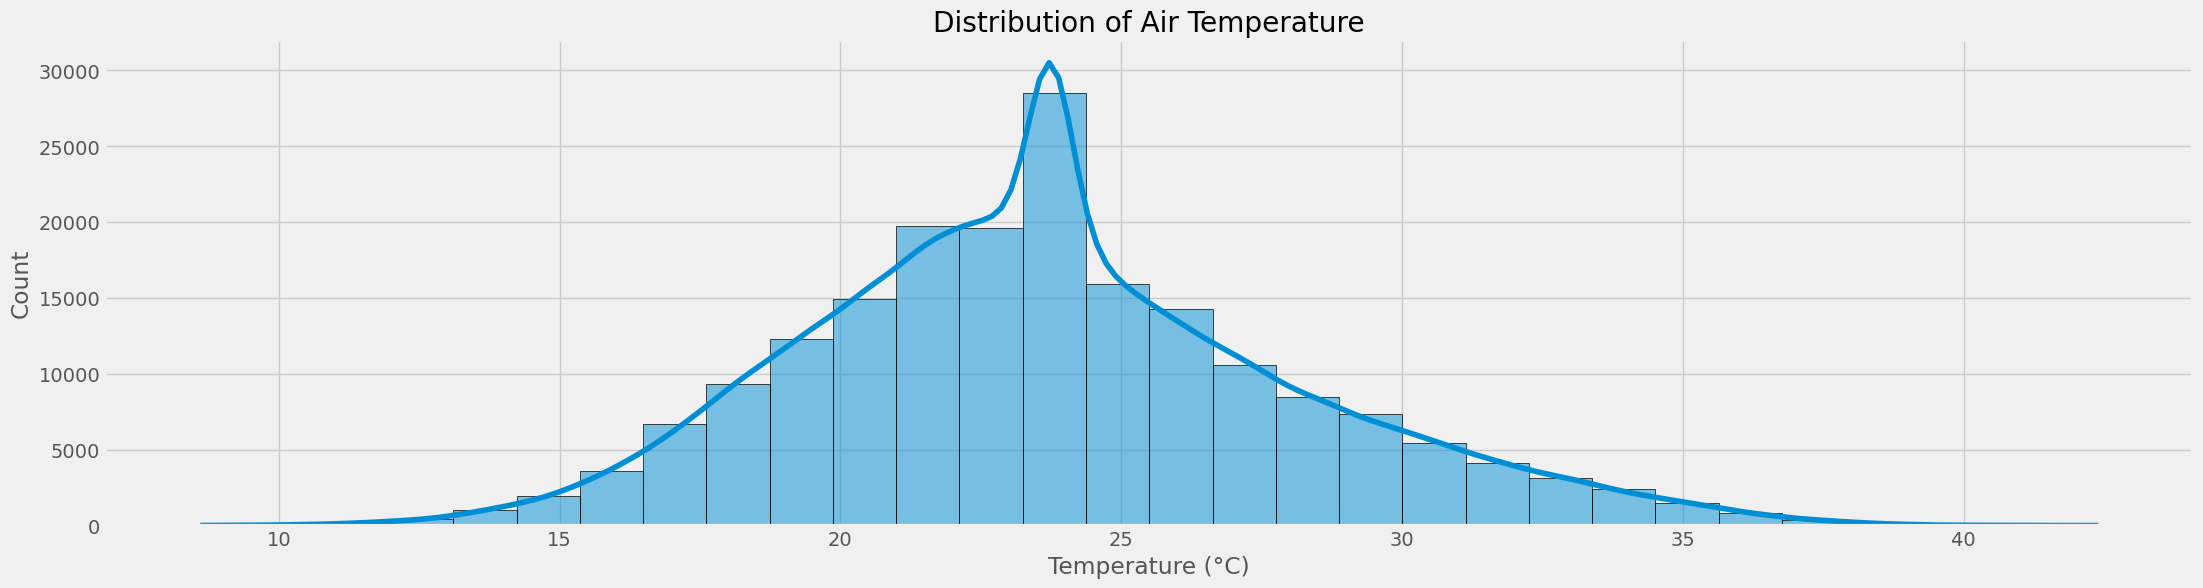

In [26]:
plt.figure(figsize=(24, 6))
sns.histplot(df4['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'], bins=30, kde=True, edgecolor='black')
plt.title('Distribution of Air Temperature')
plt.xlabel('Temperature (°C)')
plt.show()

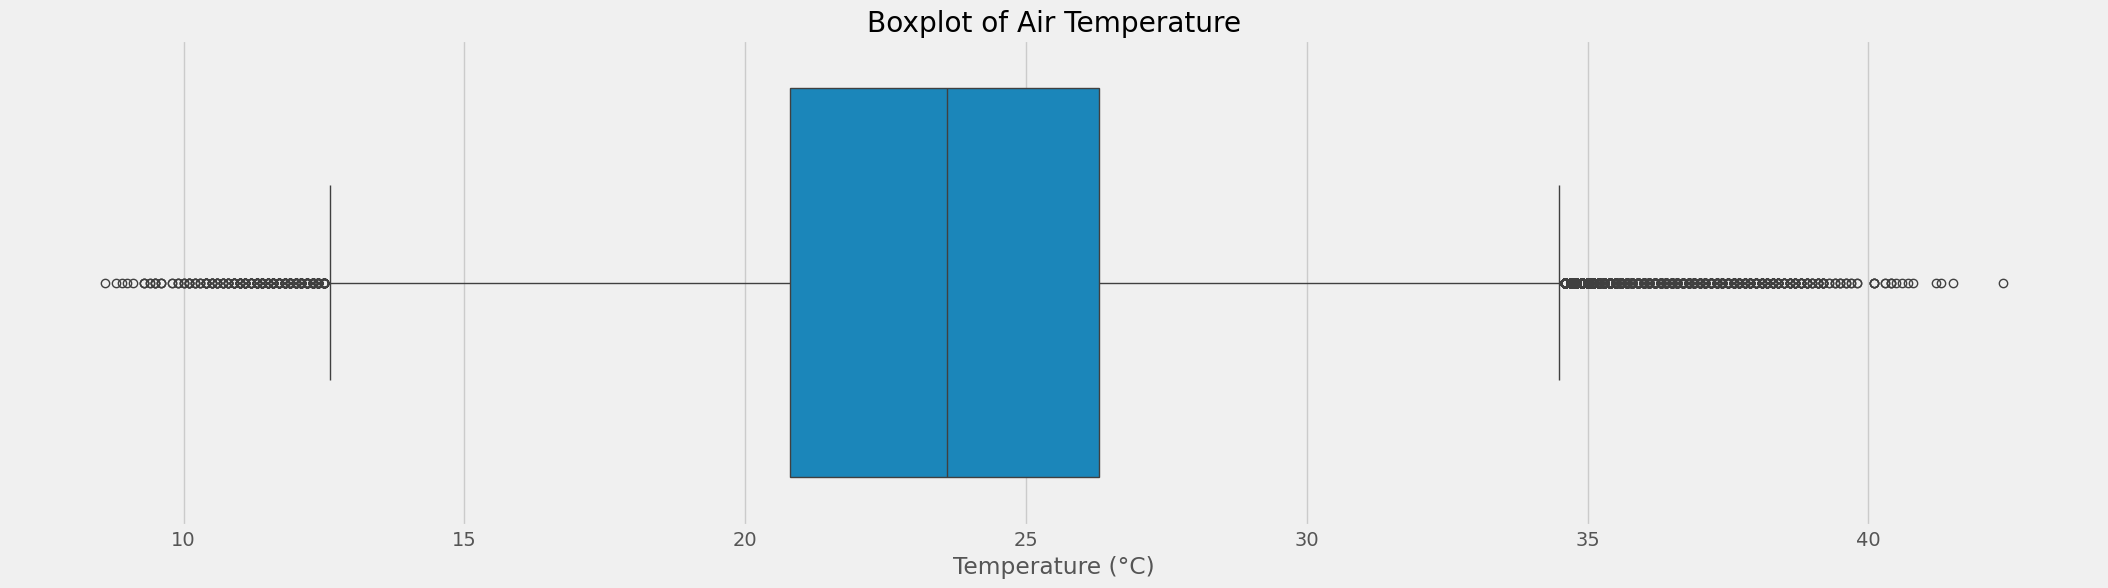

In [27]:
plt.figure(figsize=(24, 6))
sns.boxplot(x=df4['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'])
plt.title('Boxplot of Air Temperature')
plt.xlabel('Temperature (°C)')

plt.show()


## 4.2 - Bivariate Analysis

### 4.2.1 - Temperature x Year

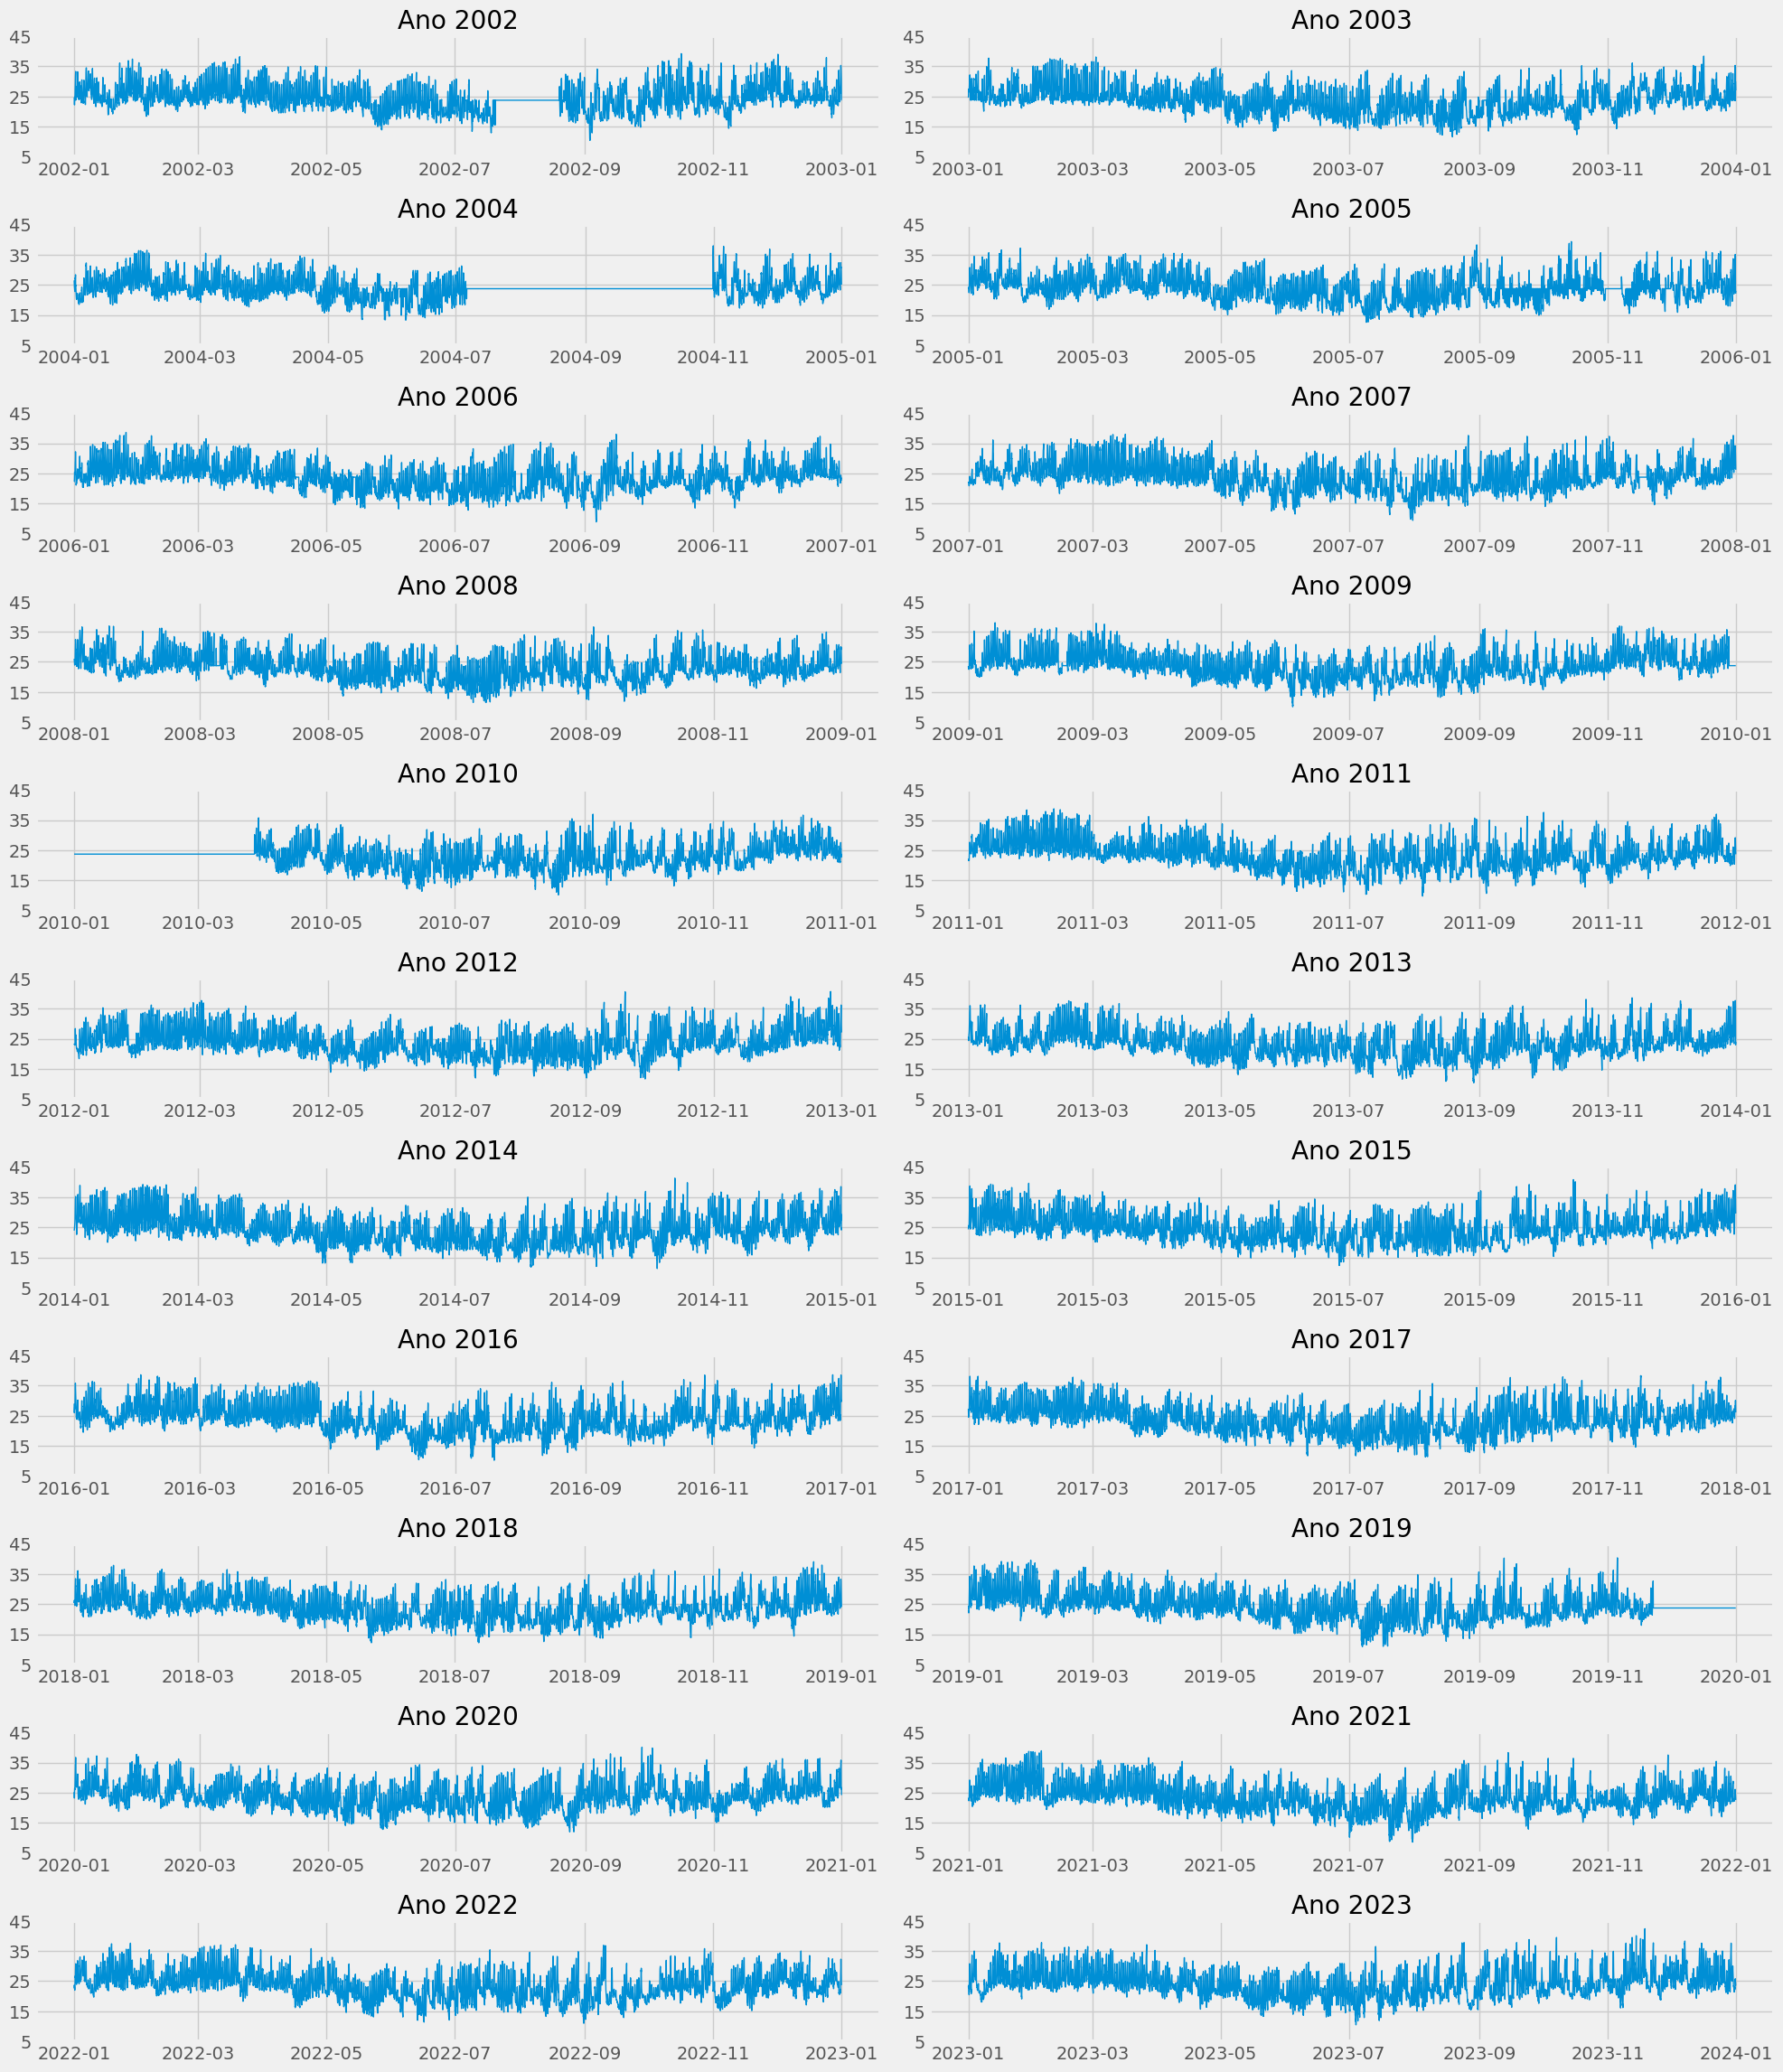

In [28]:
plt.figure(figsize=(20, 25))
for i, year in enumerate(range(2002, 2024), start=1):
    plt.subplot(12, 2, i)
    sns.lineplot(data=df4[df4['year'] == year], x='Data_Hora', y='TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)', linewidth=1)
    plt.title(f'Ano {year}')
    plt.yticks([5, 15, 25, 35, 45]) 
    plt.ylabel('')
    plt.xlabel('')
    
    
plt.tight_layout()
plt.show()

### 4.2.2 - Temperature x Week of Year

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


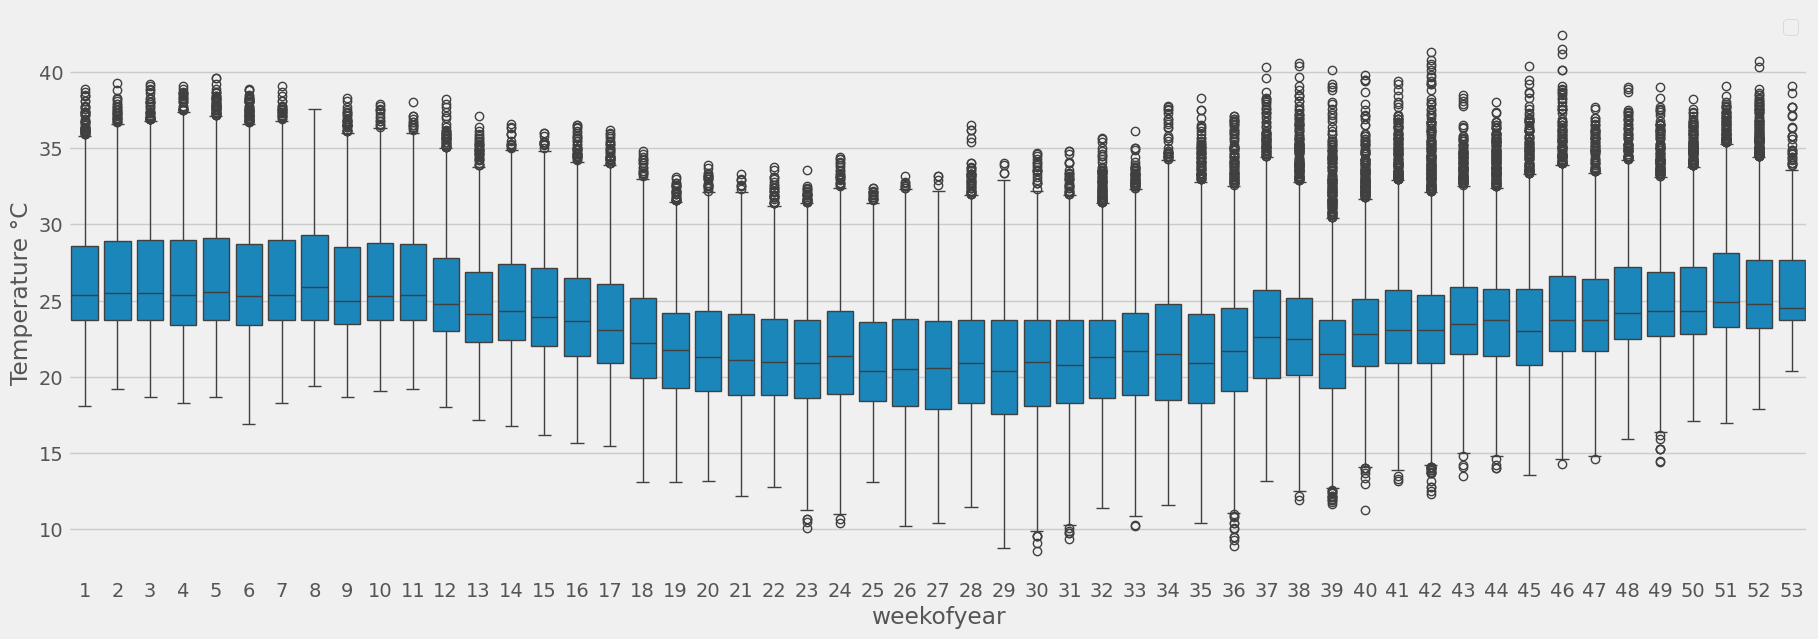

In [29]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=df4,
           x='weekofyear', 
           y='TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
           ax=ax,
           linewidth=1)

ax.set_ylabel('Temperature °C')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

### 4.2.3 - Temperature x Season

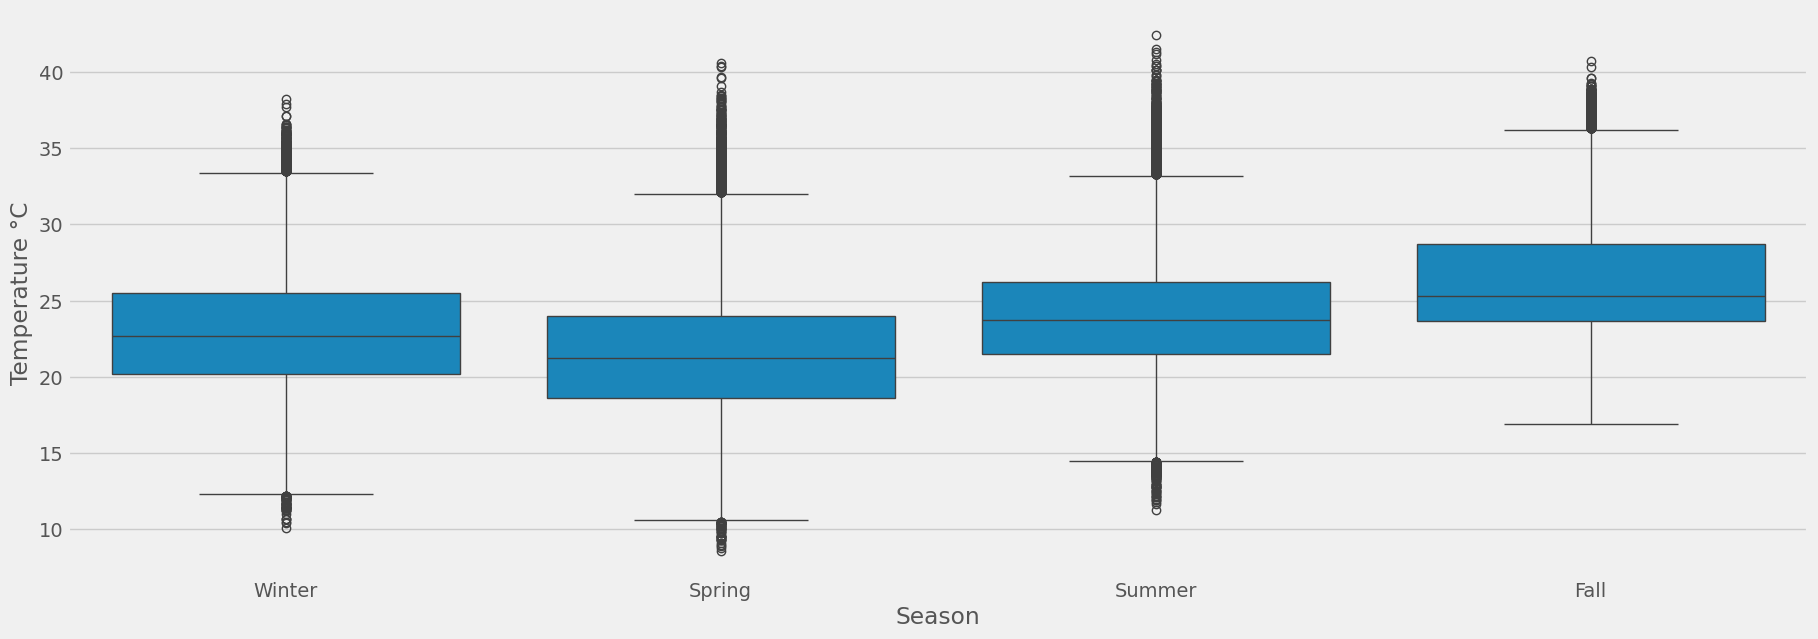

In [30]:
season_map = {1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'}

fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=df4.dropna(),
           x='season', 
           y='TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
           ax=ax,
           linewidth=1)


ax.set_xlabel('Season')
ax.set_ylabel('Temperature °C')

ax.set_xticklabels([season_map.get(x, x) for x in df4['season'].unique()])

plt.show()

### 4.2.4 - Temperature x Time of Day

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


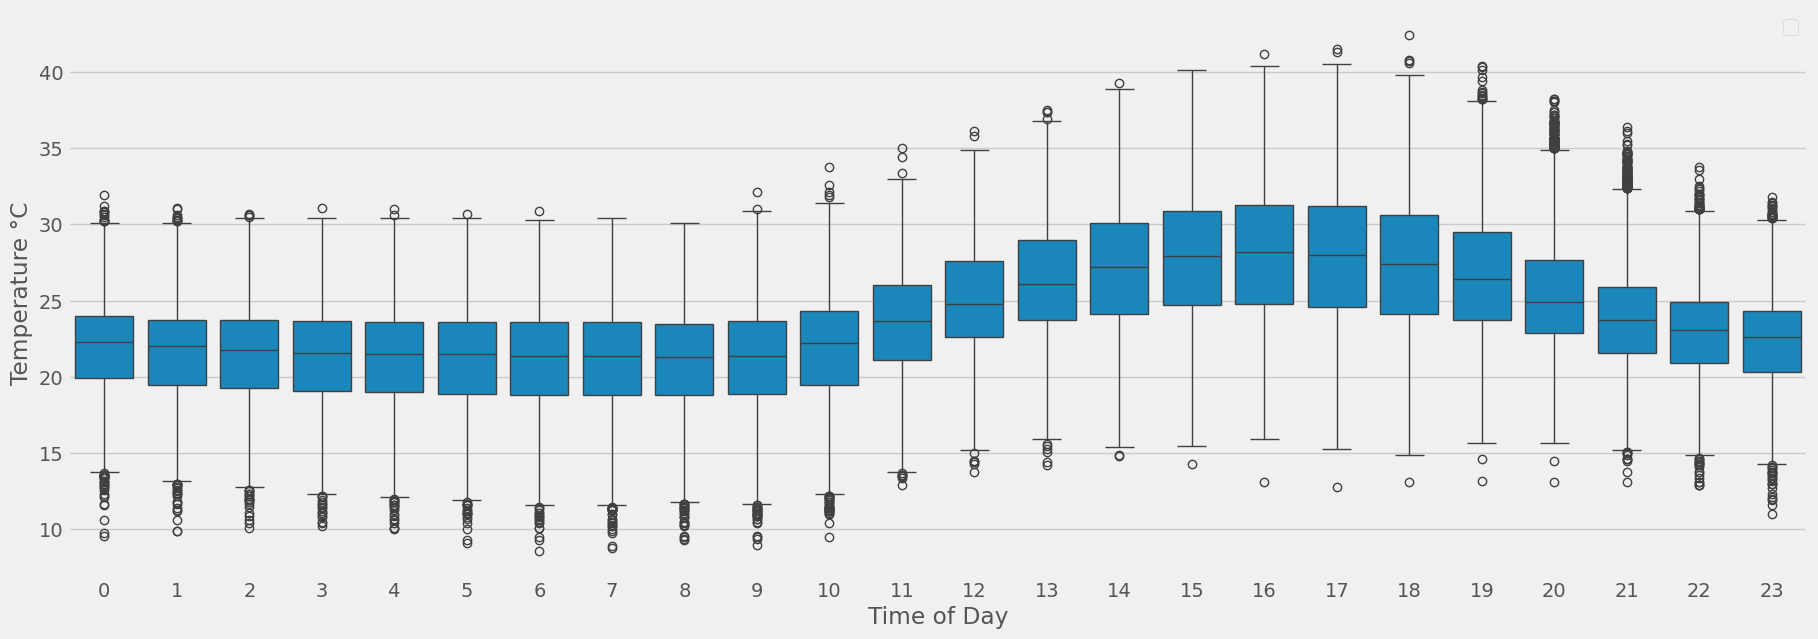

In [31]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=df4.dropna(),
           x='hour', 
           y='TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
           ax=ax,
           linewidth=1)

ax.set_xlabel('Time of Day')
ax.set_ylabel('Temperature °C')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

## 4.3 - Multivariate Analysis

### 4.3.1 - Temperature x Time of day - By Season

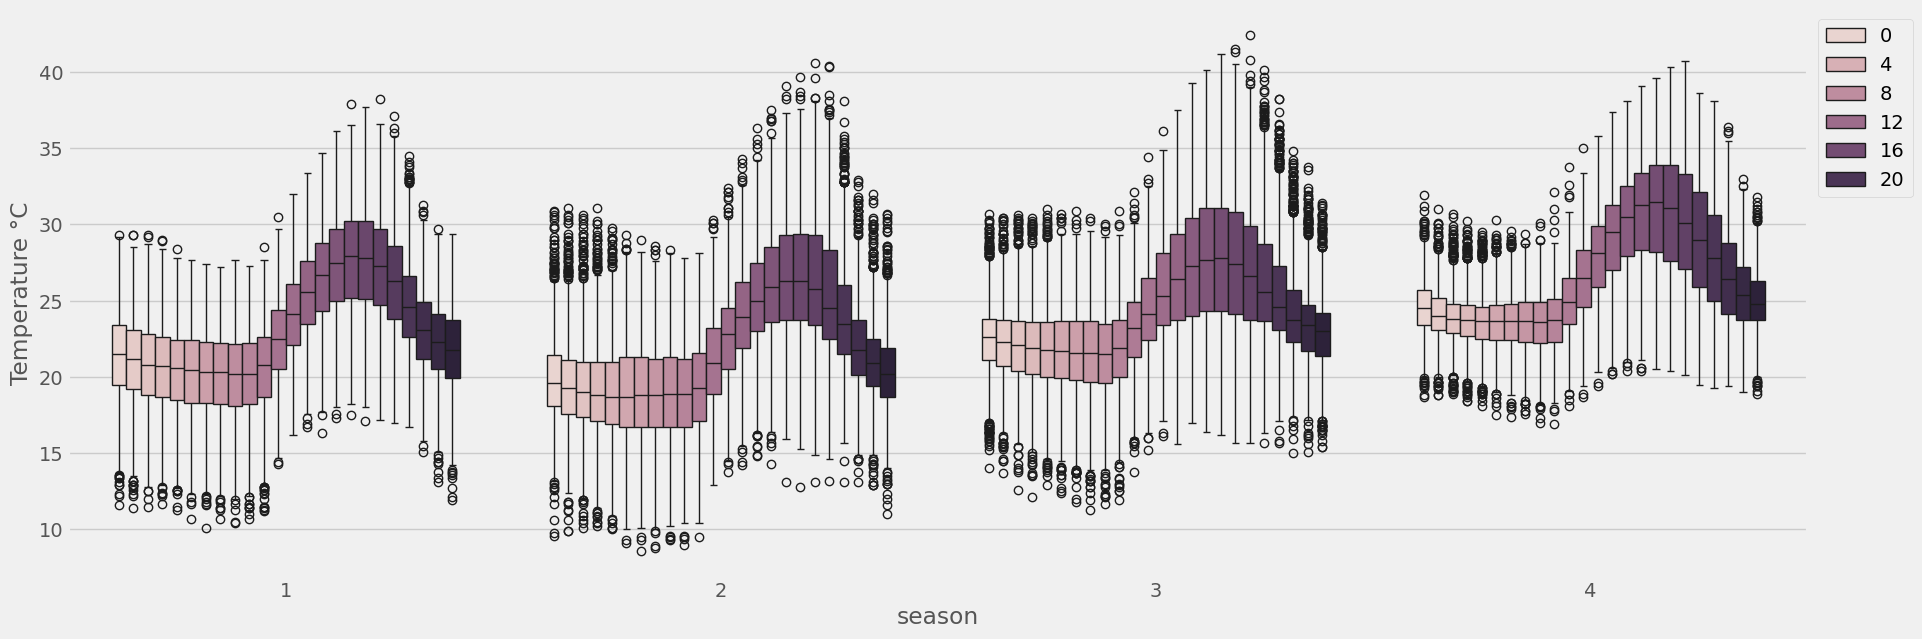

In [32]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=df4.dropna(),
           x='season', 
           y='TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
           hue='hour',
           ax=ax,
           linewidth=1)

ax.set_ylabel('Temperature °C')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

### 4.3.2 - Temperature x Year -  By Season

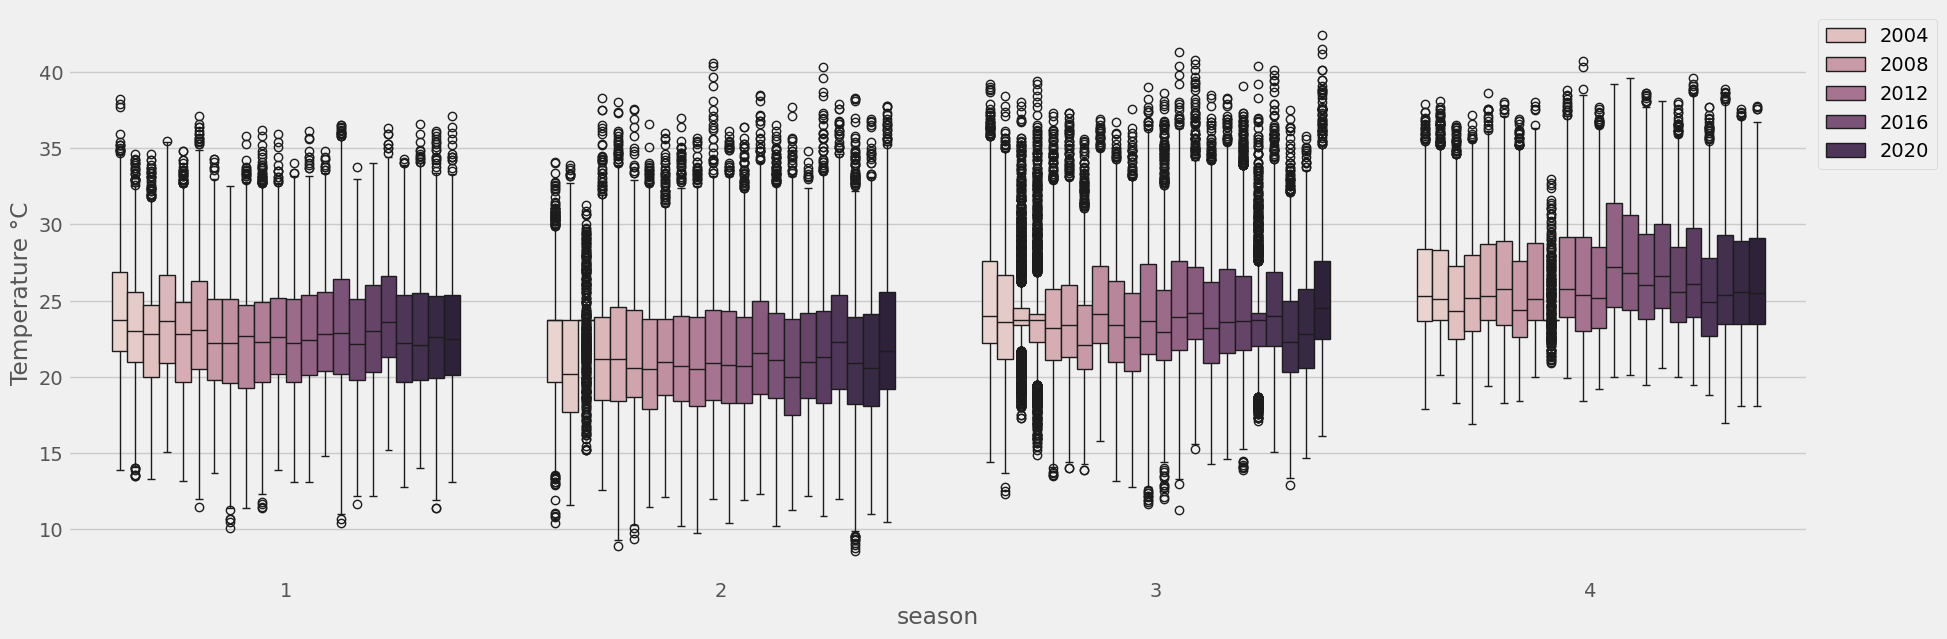

In [33]:
fig, ax = plt.subplots(figsize=(20, 7))
sns.boxplot(data=df4.dropna(),
           x='season', 
           y='TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
           hue='year',
           ax=ax,
           linewidth=1)


ax.set_ylabel('Temperature °C')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

### 4.3.3 - Heatmap

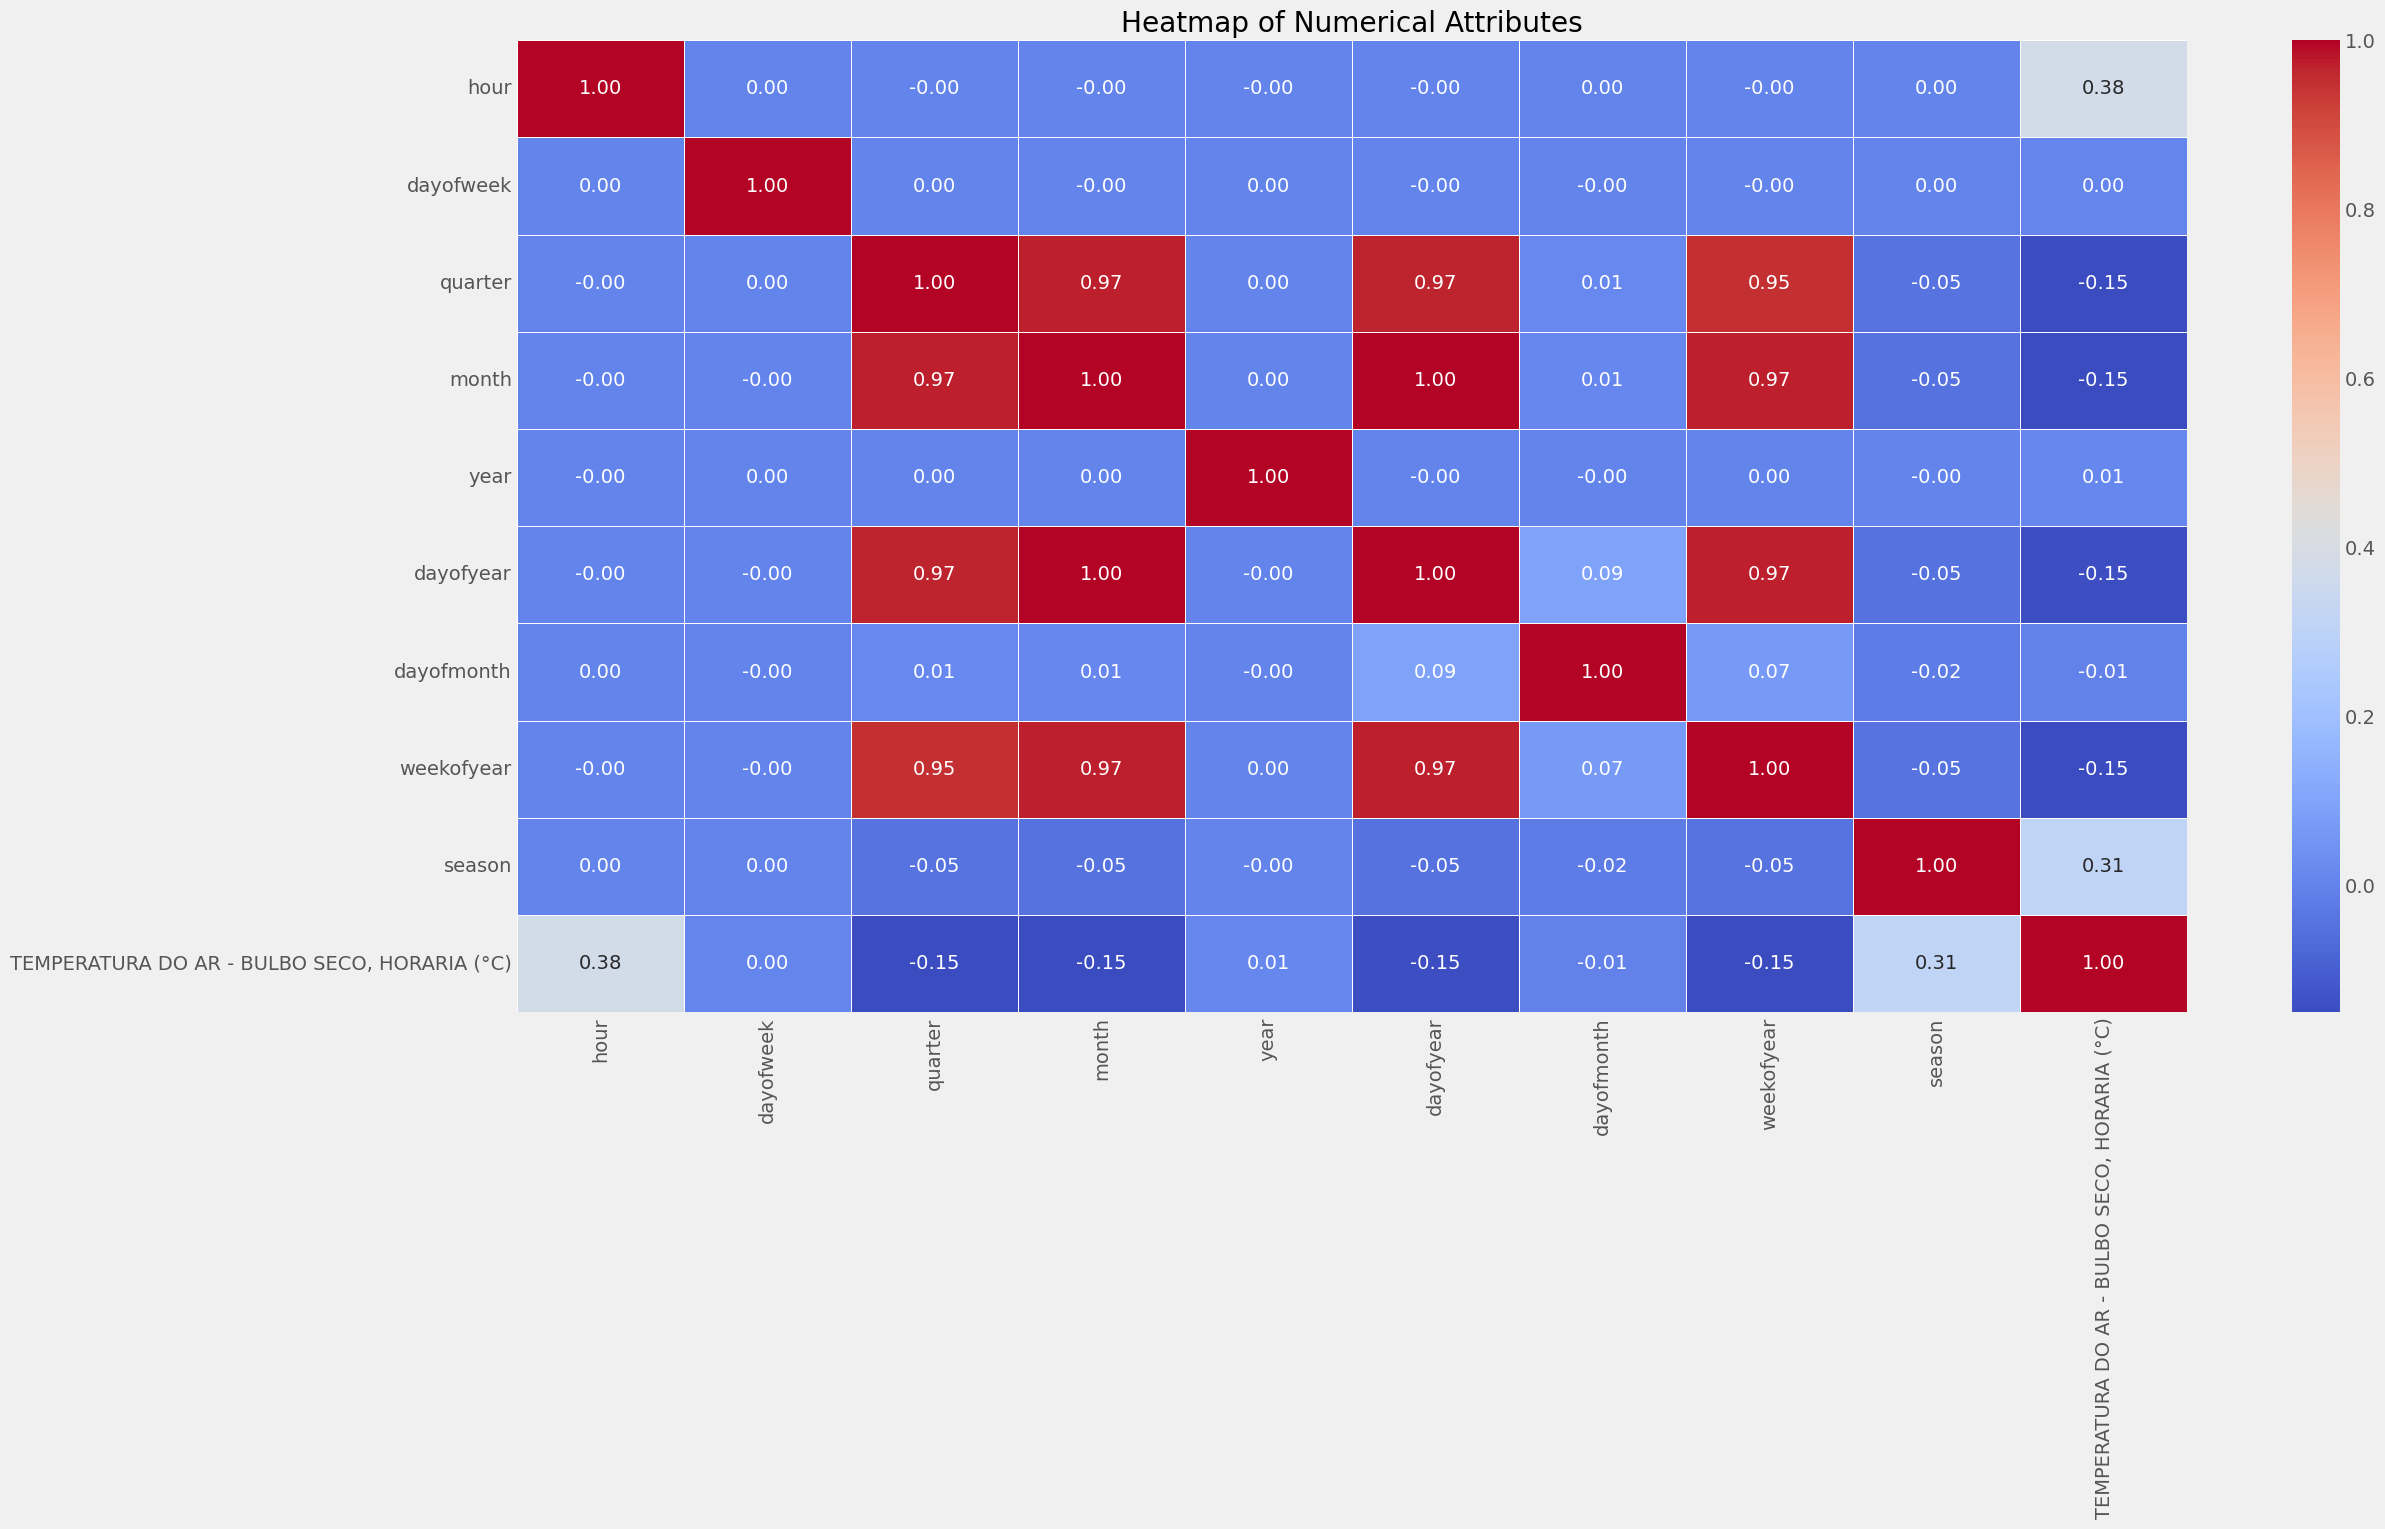

In [34]:
correlation_matrix = num_attributes.corr()


plt.figure(figsize=(24, 12))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Numerical Attributes')
plt.show()

# 5.0 - Data Preparation

In [35]:
df5 = df4.copy()

In [36]:
features = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'season']

for feature in features:
    mms = MinMaxScaler()
    df5[feature] = mms.fit_transform(df5[[feature]].values)
    pickle.dump(mms, open(fr'..\\parameter\\{feature}_scaler.pkl', 'wb'))

In [37]:
df5['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'] = np.log1p(df5['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'])

# 6.0 - Feature Selection

In [38]:
df6 = df5.copy()

In [39]:
X_train = df6.drop(columns=['Data_Hora', 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'], axis=1)
y_train = df6['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']

In [40]:
model_xgb = XGBRegressor()
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

<Figure size 1000x600 with 0 Axes>

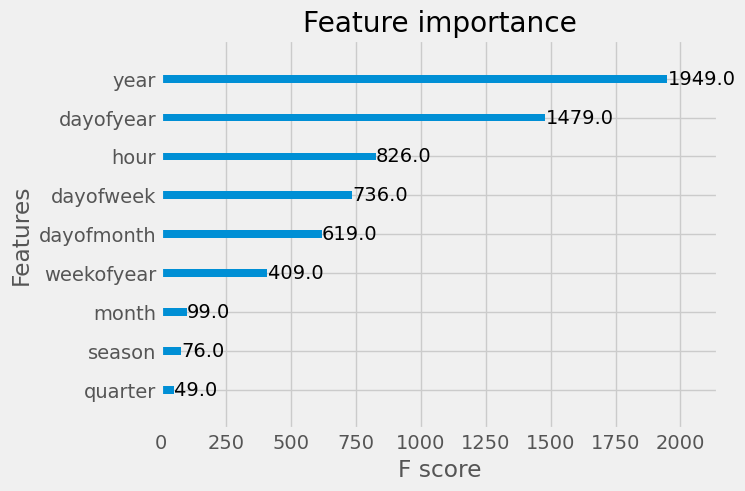

In [41]:
plt.figure(figsize=(10, 6))
plot_importance(model_xgb, importance_type='weight')
plt.show()

# 7.0 - Machine Learning

In [43]:
df7 = df6.copy()

In [44]:
df_train = df7[df7['Data_Hora'].dt.year <= 2022].copy()
df_test  = df7[df7['Data_Hora'].dt.year >  2022].copy()

In [45]:
df_train.tail()

,Data_Hora,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)"
184075,2022-12-31 19:00:00,0.826087,0.833333,1.0,1.0,0.952381,0.99726,1.0,0.980769,1.0,3.328627
184076,2022-12-31 20:00:00,0.869565,0.833333,1.0,1.0,0.952381,0.99726,1.0,0.980769,1.0,3.250374
184077,2022-12-31 21:00:00,0.913043,0.833333,1.0,1.0,0.952381,0.99726,1.0,0.980769,1.0,3.226844
184078,2022-12-31 22:00:00,0.956522,0.833333,1.0,1.0,0.952381,0.99726,1.0,0.980769,1.0,3.210844
184079,2022-12-31 23:00:00,1.000000,0.833333,1.0,1.0,0.952381,0.99726,1.0,0.980769,1.0,3.206803


In [46]:
df_test.head()

,Data_Hora,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,season,"TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)"
184080,2023-01-01 00:00:00,0.000000,1.0,0.0,0.0,1.0,0.0,0.0,0.980769,1.0,3.194583
184081,2023-01-01 01:00:00,0.043478,1.0,0.0,0.0,1.0,0.0,0.0,0.980769,1.0,3.169686
184082,2023-01-01 02:00:00,0.086957,1.0,0.0,0.0,1.0,0.0,0.0,0.980769,1.0,3.178054
184083,2023-01-01 03:00:00,0.130435,1.0,0.0,0.0,1.0,0.0,0.0,0.980769,1.0,3.202746
184084,2023-01-01 04:00:00,0.173913,1.0,0.0,0.0,1.0,0.0,0.0,0.980769,1.0,3.165475


In [47]:
X_train = df_train.drop(['Data_Hora', 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'], axis=1)
y_train = df_train['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']

X_test = df_test.drop(['Data_Hora', 'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)'], axis=1)
y_test = df_test['TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)']

In [48]:
# Model
train_model = XGBRegressor()

# Metrics
scoring = {
    'MAE': make_scorer(lambda y, yhat: mean_absolute_error(np.expm1(y), np.expm1(yhat))),
    'MAPE': make_scorer(lambda y, yhat: np.mean(np.abs((np.expm1(y) - np.expm1(yhat)) / np.expm1(y)))),
    'RMSE': make_scorer(lambda y, yhat: np.sqrt(mean_squared_error(np.expm1(y), np.expm1(yhat)))),
    'MSE': make_scorer(lambda y, yhat: mean_squared_error(np.expm1(y), np.expm1(yhat)))
}

# Cross Validation
cv_xgb_result = cross_validate(train_model, X_train, y_train, scoring=scoring, cv=5, return_train_score=False)

# Calculate the mean for each metric and round to 2 decimal places
xgb_results_df = pd.DataFrame({
    'MSE': [cv_xgb_result['test_MSE'].mean()],
    'RMSE': [cv_xgb_result['test_RMSE'].mean()],
    'MAE': [cv_xgb_result['test_MAE'].mean()],
    'MAPE': [(cv_xgb_result['test_MAPE'].mean()*100)]
}, index=['Média'])

xgb_results_df

,MSE,RMSE,MAE,MAPE
Média,10.943473,3.306715,2.555478,10.98883


# 8.0 - Hyperparameter Fine Tunnig

In [49]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_uniform('learning_rate', 0.0001, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 25),
        'n_estimators': trial.suggest_int('n_estimators', 50, 100000)
    }

    model = XGBRegressor(
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        n_estimators=params['n_estimators'],
        objective='reg:squarederror',
        eval_metric='rmse',
        n_jobs=1
    )
    
    # Evaluation using cross-validation
    rmse_scores = -cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
    
    return np.mean(np.sqrt(rmse_scores))

# Create an optimization study
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)  # Reduzir o número de tentativas

# Best hyperparameters found
print("Melhores hiperparâmetros:")
print(study.best_params)

[I 2024-06-24 17:18:42,243] A new study created in memory with name: no-name-cac2ab51-4a72-4368-b88c-805105d5881d
[I 2024-06-24 17:21:16,971] Trial 0 finished with value: 0.14931779683836946 and parameters: {'learning_rate': 0.29105674590891534, 'max_depth': 17, 'n_estimators': 5687}. Best is trial 0 with value: 0.14931779683836946.
[I 2024-06-24 17:33:13,174] Trial 1 finished with value: 0.14887132498023387 and parameters: {'learning_rate': 0.2929633827983652, 'max_depth': 12, 'n_estimators': 51282}. Best is trial 1 with value: 0.14887132498023387.
[I 2024-06-24 17:49:30,653] Trial 2 finished with value: 0.14824474579832503 and parameters: {'learning_rate': 0.09874053218258695, 'max_depth': 17, 'n_estimators': 62987}. Best is trial 2 with value: 0.14824474579832503.
[I 2024-06-24 17:54:47,243] Trial 3 finished with value: 0.15499792514911484 and parameters: {'learning_rate': 0.28864162150490597, 'max_depth': 3, 'n_estimators': 13331}. Best is trial 2 with value: 0.14824474579832503.
[

Melhores hiperparâmetros:
{'learning_rate': 0.0981092810354847, 'max_depth': 9, 'n_estimators': 48869}


# 9.0 - Model Evaluation

In [51]:
# Selected hyperparameters
xgb_params = {'learning_rate': 0.0981092810354847, 'max_depth': 9, 'n_estimators': 48869}

# Create the XGBoost model with the defined hyperparameters
xgb_final_model = XGBRegressor(learning_rate=xgb_params['learning_rate'],
                                   max_depth=xgb_params['max_depth'],
                                   n_estimators=xgb_params['n_estimators'],
                                   objective='reg:squarederror',
                                   eval_metric='rmse',
                                   n_jobs=-1)

# Fit the final model
xgb_final_model.fit(X_train, y_train)

# Make predictions
predictions = xgb_final_model.predict(X_test)

# Calculate error metrics
mse = mean_squared_error(np.expm1(y_test), np.expm1(predictions))
rmse = np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(predictions)))
mae = mean_absolute_error(np.expm1(y_test), np.expm1(predictions))
mape = np.mean(np.abs((np.expm1(y_test) - np.expm1(predictions)) / np.expm1(y_test))) * 100

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'MSE': [mse],
    'RMSE': [rmse],
    'MAE': [mae],
    'MAPE': [mape]
}, index=['Final Model'])

results_df

,MSE,RMSE,MAE,MAPE
Final Model,15.435534,3.928808,3.00058,12.344883


- The XGBoost model achieved MSE of 15.44, RMSE of 3.93, MAE of 2.88, and MAPE of 12.34%. Performance metrics differed from Prophet by approximately 17.65% to 34.16%. 

- It is important to note that the XGBoost model required an **extensive phase to identify optimal hyperparameters**, consuming significant time during modeling.

- The test was conducted over a 2-year interval, which may have favored the Prophet model and disadvantaged the XGBoost model.